### This notebook has the following Notebooks as reference on detailed analysis and reasonable way of handling the missing values, and feature generation and selection. Apart from that there are few other good notebooks from where this notebook got some value addition pieces of ideas! I wish to thank my fellow kagglers who compel me to learn and grow!

### [Kaggle Notebook] [Jane TF Keras LSTM](https://www.kaggle.com/rajkumarl/jane-tf-keras-lstm) (to fill missing values)
### [Kaggle Notebook] [Jane Day 242 Feature Generation and Selection](https://www.kaggle.com/rajkumarl/jane-day-242-feature-generation-and-selection) (to generate and select features)


# 1. IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from sklearn.model_selection import KFold
import datatable
import gc
import warnings
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
SEED = 2222
tf.random.set_seed(SEED)
np.random.seed(SEED)

# 2. LOAD DATA AND OPTIMIZE MEMORY

In [2]:
train_path = '../input/jane-street-market-prediction/train.csv'

# use datatable to load big data file
train_file = datatable.fread(train_path).to_pandas()
train_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int32(3)
memory usage: 2.4 GB


In [3]:
# It is found from info() that there are only two datatypes - float64 and int32
for c in train_file.columns:
    min_val, max_val = train_file[c].min(), train_file[c].max()
    if train_file[c].dtype == 'float64':
        if min_val>np.finfo(np.float16).min and max_val<np.finfo(np.float16).max:
            train_file[c] = train_file[c].astype(np.float16)
        elif min_val>np.finfo(np.float32).min and max_val<np.finfo(np.float32).max:
            train_file[c] = train_file[c].astype(np.float32)
    elif train_file[c].dtype == 'int32':
        if min_val>np.iinfo(np.int8).min and max_val<np.iinfo(np.int8).max:
            train_file[c] = train_file[c].astype(np.int8)
        elif min_val>np.iinfo(np.int16).min and max_val<np.iinfo(np.int16).max:
            train_file[c] = train_file[c].astype(np.int16)
train_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float16(135), int16(1), int32(1), int8(1)
memory usage: 631.5 MB


### That's a great reduction in memory usage (around 74% reduction)! It will help us go further efficiently!

# 3. HANDLING MISSING VALUES

In [4]:
print('There are %s NAN values in the train data'%train_file.isnull().sum().sum())

There are 6762701 NAN values in the train data


In [5]:
features = train_file.columns[train_file.columns.str.contains('feature')]

val_range = train_file[features].max()-train_file[features].min()
filler = pd.Series(train_file[features].min()-0.01*val_range, index=features)
# This filler value will be used as a constant replacement of missing values 


"""
A function to fill all missing values with negative outliers as discussed in the referred notebook
https://www.kaggle.com/rajkumarl/jane-tf-keras-lstm
"""
def fill_missing(df):
    df[features] = df[features].fillna(filler)
    return df  

train = fill_missing(train_file)
train = train.loc[train.weight > 0]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1981287 entries, 1 to 2390489
Columns: 138 entries, date to ts_id
dtypes: float16(135), int16(1), int32(1), int8(1)
memory usage: 538.5 MB


In [6]:
print("Now we have %d missing values in our data" %train.isnull().sum().sum())

Now we have 0 missing values in our data


# 4. FEATURE GENERATION AND SELECTION

In [7]:
"""
from notebook
https://www.kaggle.com/rajkumarl/jane-day-242-feature-generation-and-selection/comments
"""
def feature_transforms(df):
    # Generate Features using Linear shifting, Natural Logarithm and Square Root
    for f in [f'feature_{i}' for i in range(1,130)]: 
        # linear shifting to value above 1.0
        df['pos_'+str(f)] = (df[f]+abs(train[f].min())+1).astype(np.float16)
    for f in [f'feature_{i}' for i in range(1,130)]: 
        # Natural log of all the values
        df['log_'+str(f)] = np.log(df['pos_'+str(f)]).astype(np.float16)
    for f in [f'feature_{i}' for i in range(1,130)]: 
        # Square root of all the values
        df['sqrt_'+str(f)] = np.sqrt(df['pos_'+str(f)]).astype(np.float16)
    
    # Linearly shifted values are used for log and sqrt transformations
    # However they are useless since we have our original values which are 100% correlated
    # Let's drop them from our data
    df.drop([f'pos_feature_{i}' for i in range(1,130)], inplace=True, axis=1)
    
    # From the Shap Dependence plots, the following features seem to have cubic relationship with target
    cubic = [37, 39, 67, 68, 89, 98, 99, 118, 119, 121, 124, 125, 127]
    for i in cubic:
        f = f'feature_{i}'
        threes = np.full((len(df[f])), 3)
        df['cub_'+f] =np.power(df[f], threes) 
        
    # From the Shap Dependence plots, the following features seem to have quadratic relationship with target
    quad = [6, 37, 39, 40, 53, 60, 61, 62, 63, 64, 67, 68, 89, 98, 99, 101, 113, 116, 118, 119, 121, 123, 124, 125, 127]
    for i in quad:
        f = f'feature_{i}'
        df['quad_'+f] =np.square(df[f]) 
    
    return df

In [8]:
"""
from notebook
https://www.kaggle.com/rajkumarl/jane-day-242-feature-generation-and-selection/comments
"""
def manipulate_pairs(df):
    # features that can be added together or subtracted
    add_pairs = [(3,6), (15,26), (19,26), (30,37), (34,33), (35,39),(94,65), (101,4)]
    for i,j in add_pairs:
        df[f'add_{i}_{j}'] = df[f'feature_{i}']+df[f'feature_{j}']
        df[f'sub_{i}_{j}'] = df[f'feature_{i}']-df[f'feature_{j}']

    add_log_pairs = [(9,20), (22,37), (28,39), (29,25), (65,91), (74,103),(99,126), (109,7), (111,87), (112,97), (118,112)]
    for i,j in add_log_pairs:
        df[f'add_{i}_log{j}'] = df[f'feature_{i}']+df[f'log_feature_{j}']
        df[f'sub_{i}_log{j}'] = df[f'feature_{i}']-df[f'log_feature_{j}']
    # features that can be multiplied together
    mul_pairs = [(5,42), (12,66), (37,45), (39,95), (122,35)]
    for i,j in mul_pairs:
        df[f'mul_{i}_{j}'] = df[f'feature_{i}']*df[f'feature_{j}']

    mul_log_pairs = [(5,42), (6,42), (11,99), (21,42), (81,66), (98,20), (122,35)]
    for i,j in mul_log_pairs:
        df[f'mul_{i}_log{j}'] = df[f'feature_{i}']*df[f'log_feature_{j}']
    return df

In [9]:
# Perform feature generation
train = feature_transforms(train)
train = manipulate_pairs(train)

In [10]:
"""
from notebook
https://www.kaggle.com/rajkumarl/jane-day-242-feature-generation-and-selection/comments
"""
selected_features = ['weight', 'feature_1', 'feature_2', 'feature_6', 'feature_9',
       'feature_10', 'feature_16', 'feature_20', 'feature_29', 'feature_37',
       'feature_38', 'feature_39', 'feature_40', 'feature_51', 'feature_52',
       'feature_53', 'feature_54', 'feature_69', 'feature_70', 'feature_71',
       'feature_83', 'feature_100', 'feature_109', 'feature_112',
       'feature_122', 'feature_123', 'feature_124', 'feature_126',
       'feature_128', 'feature_129', 'log_feature_1', 'log_feature_2',
       'log_feature_6', 'log_feature_37', 'log_feature_38', 'log_feature_39',
       'log_feature_40', 'log_feature_50', 'log_feature_51', 'log_feature_52',
       'log_feature_53', 'log_feature_54', 'log_feature_69', 'log_feature_70',
       'log_feature_71', 'log_feature_109', 'log_feature_112',
       'log_feature_122', 'log_feature_123', 'log_feature_126',
       'log_feature_128', 'log_feature_129', 'sqrt_feature_1',
       'sqrt_feature_2', 'sqrt_feature_6', 'sqrt_feature_9', 
       'sqrt_feature_10', 'sqrt_feature_37', 'sqrt_feature_38', 'sqrt_feature_39',
       'sqrt_feature_40', 'sqrt_feature_50', 'sqrt_feature_51',
       'sqrt_feature_52', 'sqrt_feature_53', 'sqrt_feature_54',
       'sqrt_feature_56', 'sqrt_feature_69', 'sqrt_feature_70',
       'sqrt_feature_71', 'sqrt_feature_83', 'sqrt_feature_109',
       'sqrt_feature_112', 'sqrt_feature_122', 'sqrt_feature_123',
       'sqrt_feature_124', 'sqrt_feature_126', 'sqrt_feature_128',
       'sqrt_feature_129', 'cub_feature_37', 'cub_feature_39',
       'quad_feature_53', 'quad_feature_64', 'quad_feature_67',
       'quad_feature_68', 'sub_3_6', 'sub_30_37', 'add_35_39', 'add_9_log20',
       'sub_9_log20', 'add_29_log25', 'sub_29_log25', 'add_109_log7',
       'sub_109_log7', 'add_112_log97', 'sub_112_log97', 'mul_39_95',
       'mul_122_35', 'mul_6_log42', 'mul_122_log35']

### Split data into examples (X) with `selected_features` and target (y) 

In [11]:
X = train[selected_features]
y = train[[c for c in train.columns if 'resp' in c]]
y = (y>0)*1
y = (y.mean(axis=1)>0.5).astype(np.int64)
X.shape, y.shape

((1981287, 100), (1981287,))

# 5. PREPARE DATA FOR RESIDUAL NEURAL NET

In [12]:
# Expand dimension of dataset to adopt in the neural network
X = np.expand_dims(X,-2)
y = np.expand_dims(y,-1)
X.shape, y.shape

((1981287, 1, 100), (1981287, 1))

In [13]:
# save some memory
del train_file, train
gc.collect()

145

### Let's incorporate 5-fold Cross Validation

In [14]:
cv_data = []
for train, val in KFold(3).split(X,y):
    train_data = tf.data.Dataset.from_tensor_slices((X[train],y[train]))
    val_data = tf.data.Dataset.from_tensor_slices((X[val],y[val]))
    cv_data.append((train_data, val_data))

In [15]:
# save some memory
del X, y
gc.collect()

20

In [16]:
cv_data

[(<TensorSliceDataset shapes: ((1, 100), (1,)), types: (tf.float64, tf.int64)>,
  <TensorSliceDataset shapes: ((1, 100), (1,)), types: (tf.float64, tf.int64)>),
 (<TensorSliceDataset shapes: ((1, 100), (1,)), types: (tf.float64, tf.int64)>,
  <TensorSliceDataset shapes: ((1, 100), (1,)), types: (tf.float64, tf.int64)>),
 (<TensorSliceDataset shapes: ((1, 100), (1,)), types: (tf.float64, tf.int64)>,
  <TensorSliceDataset shapes: ((1, 100), (1,)), types: (tf.float64, tf.int64)>)]

# 6. RESIDUAL NETWORK MODELING

In [17]:
class Residual(tf.keras.Model):  
    """The Residual layer of ResNet"""
    def __init__(self, units):
        super().__init__()
        self.d1 = layers.Dense(units, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))
        self.d2 = layers.Dense(units, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))
        self.d3 = layers.Dense(units, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.d1(X)))
        Y = layers.Dropout(0.3)(self.bn2(self.d2(Y)))
        X = self.d3(X)
        Y += X
        return layers.Dropout(0.3)(tf.keras.activations.relu(Y))

In [18]:
class ResnetBlock(layers.Layer):
    def __init__(self, num_units, num_residuals):
        super(ResnetBlock, self).__init__()
        self.residual_layers = []
        for i in range(num_residuals):
            self.residual_layers.append(Residual(num_units))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [19]:
def create_model():
    model= tf.keras.Sequential([
        layers.Input(shape=(100,)),
        layers.GaussianNoise(0.2),
        layers.Dense(64, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        ResnetBlock(64, 2),
        ResnetBlock(128, 2),
        ResnetBlock(256, 2),
        ResnetBlock(512, 2),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=['accuracy'])
    return model


# 7. TRAINING

In [20]:
train_accu = []
train_loss = []
val_accu = []
val_loss = []
models = []
fold = 1
for train, val in cv_data:
    model = create_model()
    hist = model.fit(train_data.repeat(), 
                 epochs=40, 
                 steps_per_epoch=200, 
                 batch_size=5120, 
                 validation_data=val_data, 
                 validation_steps=100, 
                 verbose=0)
    models.append(model)
    train_accu.append(hist.history['accuracy'])
    train_loss.append(hist.history['loss'])
    val_accu.append(hist.history['val_accuracy'])
    val_loss.append(hist.history['val_loss'])
    print('\n Fold completed: ',fold, '\n')
    fold += 1    


 Fold completed:  1 


 Fold completed:  2 


 Fold completed:  3 



### Let's visualize the model performance

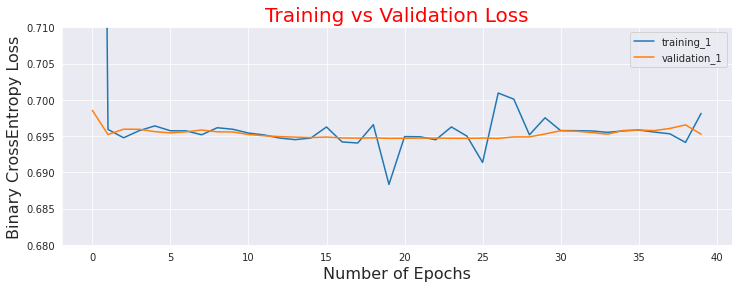

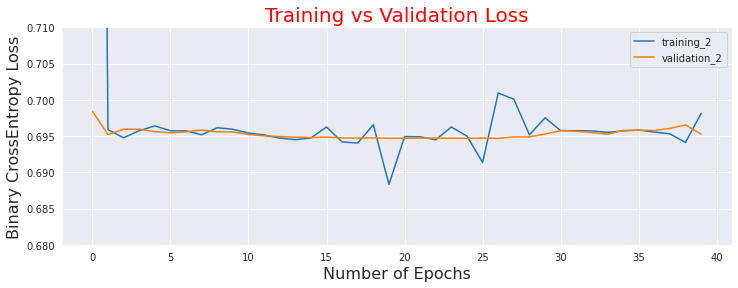

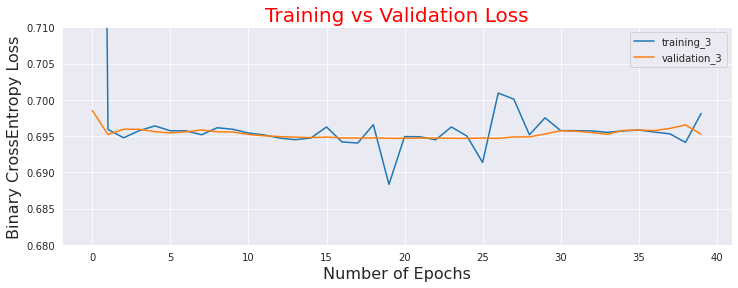

In [21]:
# plt.figure(figsize=(12,4))
for i in range(3):
    plt.figure(figsize=(12,4))
    plt.plot(train_loss[i], label=f'training_{i+1}')
    plt.plot(val_loss[i], label=f'validation_{i+1}')
    plt.ylabel('Binary CrossEntropy Loss', size=16)
    plt.xlabel('Number of Epochs', size=16)
    plt.title('Training vs Validation Loss', color='r', size=20)
    plt.ylim([0.68,0.71])
    plt.legend()
    plt.show()

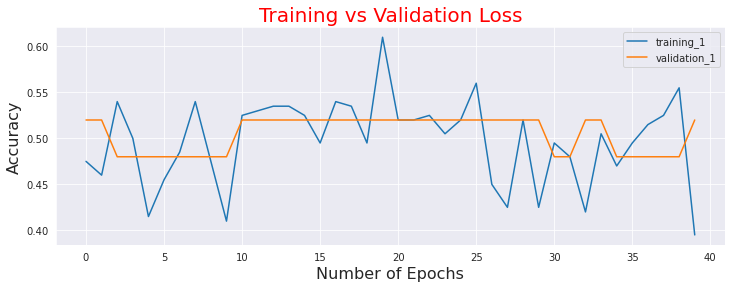

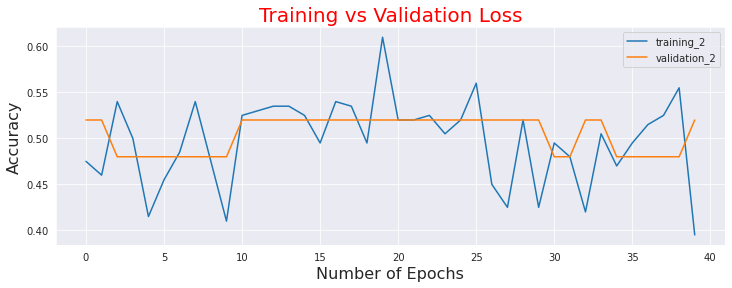

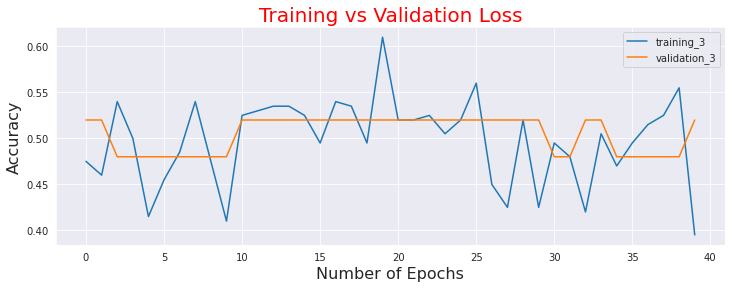

In [22]:
# plt.figure(figsize=(12,4))
for i in range(3):
    plt.figure(figsize=(12,4))
    plt.plot(train_accu[i], label=f'training_{i+1}')
    plt.plot(val_accu[i], label=f'validation_{i+1}')
    plt.ylabel('Accuracy', size=16)
    plt.xlabel('Number of Epochs', size=16)
    plt.title('Training vs Validation Loss', color='r', size=20)
    plt.legend()
    plt.show()

### Model performance seems quite same for all three folds of data

## Save model for inference

In [23]:
for m in range(3):
    model = models[m]
    model.save_weights(f'resnet_select_feature_{m+1}.h5', save_format='h5')
    print(f'model_{m+1} weights saved successfully.')

model_1 weights saved successfully.
model_2 weights saved successfully.
model_3 weights saved successfully.


### Thank you for your time!